# Python Webscraping Project

In [1]:
# -*- coding: utf-8 -*-

Author : Fkih Younès 
Used Python version : 3.x
Last Modification Date : 30/10/2017 8pm
linkedIn : https://www.linkedin.com/in/younes-fkih/

## Project description 

We are working on the detection of Rent announcements Rent amount predection in Paris.
This Project maybe extended to support other cities. It's a Proof Of Concept.

## Project Implementation

### Import Section for used libraries

In [2]:
from bs4 import BeautifulSoup  #Importing Library For Web scrapping (XML and HTML)
import requests #Importing Library For HTTP Request Method
from lxml import html # XML abd HTML parser
import lxml.etree as et #XML Library to parse SVG File and Edit it before plot
import pandas as pd # Maths Library
from unidecode import unidecode # Library to unicode string
import re # Library for regular Expressions
from IPython.display import display, HTML # Library for pretty printing pandas data_frames
from sklearn.utils import shuffle # Library used to shuffle rows in data frames.
from IPython.display import IFrame # Library to import a google's map IFRAME into notrebook
from IPython.display import SVG, display # Library to render svg Paris map
import numpy as np #Maths Library 
import matplotlib.pyplot as plt # Viz Library
from sklearn import datasets, linear_model #training Library for ML
from sklearn.metrics import mean_squared_error, r2_score #Score and error calculation Library
import seaborn as sns #Library imported from plots

### Defining Webscraping functions 

This function will return a list of json. 
Each json contains article's titles and links

In [3]:
def getJSONLinksFromContentReponse(Response):
    
    docHtmlContent = Response.content #Getting the body content of the httpResponse
    html_soup = BeautifulSoup(docHtmlContent, 'html.parser') # Parsing the Response Body
    section = html_soup.find("section", {"class": "tabsContent block-white dontSwitch"}) #Searching for section containing list of announcement
    ul = section.find("ul") # Getting List of the announcements
    li = ul.findAll("li") # Getting announcements Elements from the previous List
    announcementsList = [] # List of announcements
    for item in li:
        '''
        Parsing each announcement and 
        Making a JSON which contains the details.
        Cleaning Data for the URL of the announcement,
        And the Category of the annoucement
        and preparing it for a Future use
        '''
        announcementsList.append({ 'PostTitle' : item.find('a')['title'],'link' : "https://"+(item.find('a')['href'][2:])}) 
    return announcementsList


This Function will get Information from each Announcements.
It will return a list contaning details about each announcement. 
In this function we will try to scrap every thing (Unused fields in this project) .. Maybe it will be usefull in the futur.

In [4]:
def proceedAnalysis(theAnnouncementsJSONList,isProfessionalAnnouncement):    
   
    titleList= []
    postLinkList= []
    rentAmountList= []
    buildingPostCodeList= []
    posthasPhoneContactList= []
    posthasMailContactList= []
    postNumberOfPhototList= []
    postDescriptionList= []
    isBuildingfurnishedList= []
    buildingAreaList= []
    buildingRommsNumberList= []
    isProfessionalAnnouncementList = [] 
    
    if(isProfessionalAnnouncement) :
        print("Parsing scraped HTML Responses for professional announcements")          
    else :
        print("Parsing scraped HTML Responses for inidvidual announcements")   
        
    for articleJSON in theAnnouncementsJSONList:
        title = articleJSON["PostTitle"]
        postLink = articleJSON["link"]
        pageAnnouncementResponse = requests.get(postLink) # Opening the url of the announcement
        if(pageAnnouncementResponse.ok) : #Announcement Response is well            
            docHtmlContent = pageAnnouncementResponse.content #Getting the body content of the httpResponse
            #Solving Problems with encoding
            try :
                DOM = html.fromstring(docHtmlContent.decode('utf8'))  # DOM is the html document oriented object representation
            except UnicodeDecodeError :
                DOM = html.fromstring(docHtmlContent.decode('latin-1'))  # DOM is the html document oriented object representation

            MaybeInsertedIntoDataFrame = True #boolean which will control saving of the data (Yes/No if there's needed fields)
            #Getting tagged (id,class or itemprop) fields
            #Getting the Rent Amount
            try :
                rentAmount = int("".join(re.findall('\d+', (DOM.xpath('//h2[@itemprop="price"]/span/text()')[1]))))             
            except IndexError :
                MaybeInsertedIntoDataFrame = False
           
            #Getting Post Code of the building
            try :
                buildingPostCode = int(re.findall('\d+',DOM.xpath('//span[@itemprop="address"]/text()')[0])[0])
            except IndexError :
                MaybeInsertedIntoDataFrame = False
            
            #Getting number of photos of the announcement (There is a problem when the post has no photo si we catch this case)
            try:
                postNumberOfPhoto = (re.findall('\d+',DOM.xpath('//p[@class="item_photo"]/text()')[0]))[0]
            except IndexError: 
                #When the Post hasn't any photo
                if(len(DOM.xpath('//div[@class="item_image empty"]'))):
                    postNumberOfPhoto = 0
                else :
                    postNumberOfPhoto = 1
                    
            #Getting the number of the available contacts in the announcement 
            postNumberOfContact = len(DOM.xpath('//div[@class="box-grey-light mbs align-center"]/div')[0].getchildren())
            posthasPhoneContact = len(DOM.xpath('//button[@class="button-orange large phoneNumber trackable"]'))
            posthasMailContact = 0
            if(postNumberOfContact - posthasPhoneContact > 0):
                posthasMailContact = 1
            
            #Getting the description of the announcement 
            try :
                postDescription = (DOM.xpath('//p[@itemprop="description"]/text()')[0])       
            except IndexError :
                MaybeInsertedIntoDataFrame = False
            
            
        
            
            # Getting non Tagged fields by Text Content
            isBuildingfurnished = 0 #default value "non meublé"
            buildingArea = 15 #default Value in m² 
            buildingRommsNumber = 1 #default rooms number equals 1
            othersNonTaggedFields = DOM.xpath('//section[@class="properties lineNegative"]/div[@class="line"]/h2[@class="clearfix"]/span/text()')[:8]
            
            #Checking if other informations exist
            FoundOtherFields = True
            for elt in ["Meublé / Non meublé","Pièces","Surface"]:
                FoundOtherFields = FoundOtherFields and (elt in othersNonTaggedFields)
                
            for cpt in range(0,len(othersNonTaggedFields)):
                key = (othersNonTaggedFields[cpt].strip())
                if key in ["Meublé / Non meublé","Pièces","Surface"]: # Ces Champs nous concernent pour la suite
                    value = othersNonTaggedFields[cpt+1].strip()
                    if((key == "Meublé / Non meublé") and  (value == "Meublé")):
                        isBuildingfurnished = 1
                    if(key == "Pièces"):
                        buildingRommsNumber = int(value)
                    if(key == "Surface"):
                        buildingArea = re.findall('\d+',value)[0]      
            
            
            ### Cleaning Data ###
            #Treatment of aberrant values, we won't insert illogic values in our dataFrame
            squareMeterRent = (float(rentAmount)/float(buildingArea))
            if(squareMeterRent > 60 or squareMeterRent < 28 ):
                MaybeInsertedIntoDataFrame = False
            # We estimate that a Rent in paris is at least at 450 euros
            if(float(rentAmount) < 450):
                MaybeInsertedIntoDataFrame = False
           
            #Inserting only completely Filled Rows
            if(FoundOtherFields and MaybeInsertedIntoDataFrame):
                titleList.append(title)
                postLinkList.append(postLink)
                rentAmountList.append(rentAmount)
                buildingPostCodeList.append(buildingPostCode)
                postNumberOfPhototList.append(postNumberOfPhoto)
                posthasPhoneContactList.append(posthasPhoneContact)
                posthasMailContactList.append(posthasMailContact)
                postDescriptionList.append(postDescription)
                isBuildingfurnishedList.append(isBuildingfurnished)
                buildingAreaList.append(buildingArea)
                buildingRommsNumberList.append(buildingRommsNumber)
                isProfessionalAnnouncementList.append(isProfessionalAnnouncement) #Extracting from PRO agencies so there is no fraudes
            
    print("Contructing Data Frame")      
    df_Announcements = pd.DataFrame(list(zip(buildingPostCodeList,buildingRommsNumberList,isBuildingfurnishedList,buildingAreaList,isProfessionalAnnouncementList,rentAmountList)),\
    columns = ['Zip Code','Rooms Number','is furnished','Area','Rent from Agency','Rent(€)'])
    return df_Announcements


We observed Some different values for the same Zip Code.
for example 75116 for 75016. So this function aim to treat this issue.


In [5]:
def processZipCodes(df):
    for i in range(0,len(df["Zip Code"])):
        zipCode =df["Zip Code"][i]
        df.at[i, "Zip Code"] = "750"+(str(zipCode)[-2:])
    return df

This is tha scrapping function. It will grab data from the net.
Then it'll pass them to another function which will process them.
Then it'll save these scrapped data into an Excel which will be used
for vizualisation and machine Learning
    

In [6]:
def Scrapping(startPage,endPage):    
    # Init For our list and http Response status
    tabProffessionalResponses = []
    httpProffessionalResponseSuccess = True 
   
    tabIndividualResponses = []
    httppIndividualResponseSuccess = True 
    
    # We'll need it later for testing our classification model
    try:
        httpIndividualResponse = requests.get('https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?ret=1&ret=2&f=p') #Getting HTTPReponse from URL    
        httpIndividualResponseSuccess  = httpIndividualResponse.ok # Ok is a property of the Reponse which is a Boolean
    except:
        return None
    
    # Getting list of professional Announcements ( 1 page ~ 35 announcements )
    for pageNumber in range(startPage,endPage+1) : 
       
        try:
            #Scraping Proffesional Announcements
            httpProffessionalResponse = requests.get('https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o='+str(pageNumber)+'&ret=1&ret=2&f=c') #Getting HTTPReponse from URL        
            httpProffessionalResponseSuccess  = (httpProffessionalResponseSuccess and httpProffessionalResponse.ok) # Ok is a property of the Reponse which is a Boolean
            tabProffessionalResponses.append(httpProffessionalResponse)

            #Scraping Individual Announcements
            httpIndividualResponse = requests.get('https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o='+str(pageNumber)+'&ret=1&ret=2&f=p') #Getting HTTPReponse from URL        
            httpIndividualResponseSuccess  = (httpIndividualResponseSuccess and httpIndividualResponse.ok) # Ok is a property of the Reponse which is a Boolean
            tabIndividualResponses.append(httpIndividualResponse)
        except:
            return None
    
    if(  httpIndividualResponseSuccess and httpProffessionalResponseSuccess): # ALL IS OK
        print("Reponses are available and ready for parse")
        
        listOfProffessionalAnnouncements = []
        for professionalAnnoucementsResponse in tabProffessionalResponses :
            listOfProffessionalAnnouncements = listOfProffessionalAnnouncements + getJSONLinksFromContentReponse(professionalAnnoucementsResponse) #Construction of List of details for Announcements and concatenate them
       
        listOfIndividualAnnouncements = []
        for individualAnnoucementsResponse in tabIndividualResponses :
            listOfIndividualAnnouncements = listOfIndividualAnnouncements + getJSONLinksFromContentReponse(individualAnnoucementsResponse) #Construction of List of details for Announcements and concatenate them

        dfProfessional = proceedAnalysis(listOfProffessionalAnnouncements,1) #getting informations from each Announcements and constructing data Frame
        dfIndividual = proceedAnalysis(listOfIndividualAnnouncements,0) #getting informations from each Announcements and constructing data Frame
        allFrames = [dfProfessional, dfIndividual]
        resultFrame = pd.concat(allFrames,ignore_index=True)  # Concatenating  data frames
        resultFrame = shuffle(resultFrame) #shuffling rows in the result Data frame
        resultFrame.drop_duplicates() # Eliminating duplicated rows from the data frame.
        resultFrame = processZipCodes(resultFrame) 
        return resultFrame
       
    else : # Code = 404,500,501 ... Error Code 5xx or 4xx from the documentation
        print("A problem is occured ! Please check your internet connexion")
        return None
        



In [7]:
train_DataFrame = Scrapping(1,30)
test_DataFrame = Scrapping(31,33)
if( isinstance(train_DataFrame, pd.DataFrame) and isinstance(test_DataFrame, pd.DataFrame)): 
    
    '''
    At This moment we have a data set without lack of informations and without duplicated rows
    Informations which are stored in this data set is exploitable in this state. (Numeric Value, Boolean (0,1))
    We'll save this data frame into an Excel which will be used later from training and data viz.
    '''
    writer = pd.ExcelWriter('DB_ML.xlsx')
    train_DataFrame.to_excel(writer,sheet_name='dataSheet',index = False)
    writer.save()
    
    writer = pd.ExcelWriter('DB_ML_TEST.xlsx')
    test_DataFrame.to_excel(writer,sheet_name='dataSheet',index = False)
    writer.save()
    print("All is Ok ! You can proceed :D ")
    display(train_DataFrame) # printing Train data frames
else : 
    print("There is a problem !! Please check your connexion :/")

Reponses are available and ready for parse
Parsing scraped HTML Responses for professional announcements
Contructing Data Frame
Parsing scraped HTML Responses for inidvidual announcements
Contructing Data Frame
Reponses are available and ready for parse
Parsing scraped HTML Responses for professional announcements
Contructing Data Frame
Parsing scraped HTML Responses for inidvidual announcements
Contructing Data Frame
All is Ok ! You can proceed :D 


,Zip Code,Rooms Number,is furnished,Area,Rent from Agency,Rent(€)
111,75011,2,1,31,1,1090
78,75018,2,1,19,1,840
247,75006,3,0,60,1,1790
1287,75017,2,1,34,0,1190
1030,75012,1,0,30,0,980
582,75007,3,0,70,1,2400
784,75004,1,1,25,0,1250
1386,75016,2,1,32,0,1700
17,75020,1,1,19,1,800
892,75017,2,1,26,0,1000


### Defining Vizualisation Functions

In [8]:
df_Viz = pd.read_excel('./DB_ML.xlsx') # Getting DB For machien Learning and Vizualisation. 

This Function will show us the number of announcements in an interactive
SVG Image.
This Map and the algorithm which manipulate it were created by Younès Fkih.
We didn't find a map which shows Paris districts so we implemented it. 

In [9]:
def showAnnoucementRepartition():
    
    statsAnnoucements = (df_Viz.groupby('Zip Code').size())
    statsAnnoucementsDictionnary={}
    #Changing list of tuple to a dictionnary to offer the possibility to get directrly the value by name
    for (ZipCode,nbAnnouncements) in statsAnnoucements.iteritems():
           statsAnnoucementsDictionnary[str(ZipCode)] = nbAnnouncements
    
    filename ='./paris.svg'
    with open( filename, 'r') as infile: 
        tree = et.parse(infile)
        svg = tree.getroot()
    
    '''
        Modifying tooltip SVG Content Text with the stats
    '''
    for arrEndingRegex in range(1,21):
        zipeCode= str(75000+arrEndingRegex)
        announcementsNumber = 0
        if(zipeCode in statsAnnoucementsDictionnary):
           announcementsNumber=statsAnnoucementsDictionnary[zipeCode]
        idKey = "arrondissementNumber"+str(arrEndingRegex)        
        tree.xpath('//*[@id="'+idKey+'"]')[0].text = str(announcementsNumber)    
    display(SVG(et.tostring(tree, pretty_print=True)))
    display(HTML('<h4><center>ads by district</center></h4>'))

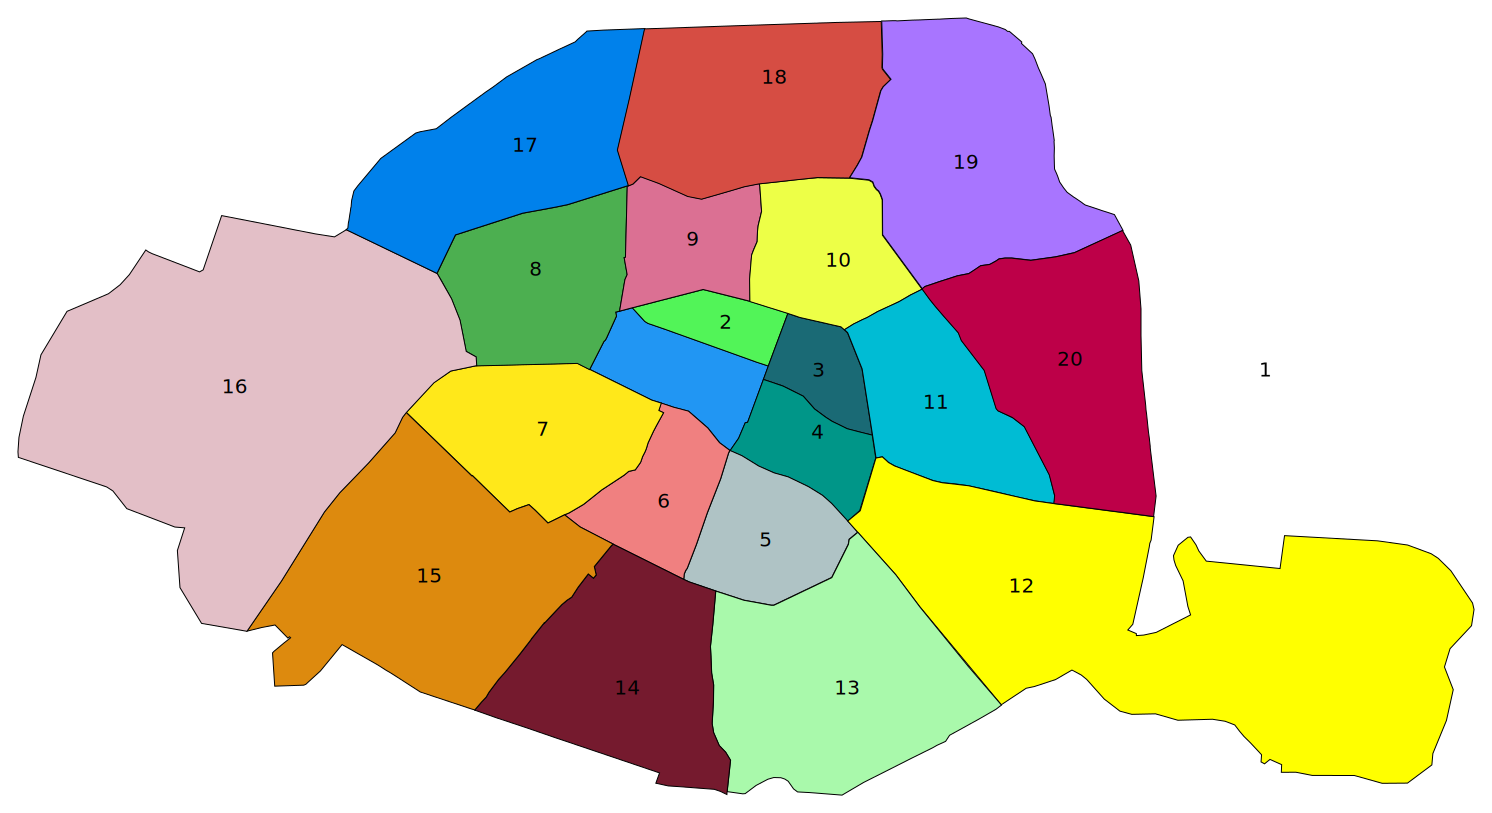

In [10]:
showAnnoucementRepartition()

In [11]:
def generateBarChartForAnnouncements():
    ListArrond = df_Viz["Zip Code"].unique()
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    for (ZipCode,nbAnnouncements) in df_Viz.groupby(['Zip Code','Rent from Agency']).size().iteritems(): #Filtering on Ads Owner and Zip Codes
            if(not (str(ZipCode[0]) in StatsPerCategoryDistrict )):
                StatsPerCategoryDistrict[str(ZipCode[0])] = {}
                StatsPerCategoryDistrict[str(ZipCode[0])]["Individual"] = nbAnnouncements
            else :
                StatsPerCategoryDistrict[str(ZipCode[0])]["Agency"]=nbAnnouncements

    #Constructing list of tuples for the plot library
    AnnouncementsAgency = ()                         
    AnnouncementsIndividual = ()                         
    for zipCode in sorted(ListArrond) :
        AnnouncementsAgency = AnnouncementsAgency + (StatsPerCategoryDistrict[str(zipCode)]["Agency"],)
        AnnouncementsIndividual = AnnouncementsIndividual + (StatsPerCategoryDistrict[str(zipCode)]["Individual"],)

    ind = np.arange(20)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(ind, AnnouncementsAgency, width, color='r')
    rects2 = ax.bar(ind + width, AnnouncementsIndividual, width, color='B')
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of announcements')
    ax.set_xlabel('District')
    ax.set_title('Rent Announcements by owner and district')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)])
    ax.legend((rects1[0], rects2[0]), ('Agency', 'Individual'))

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    #Modifying the plot size
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.show()


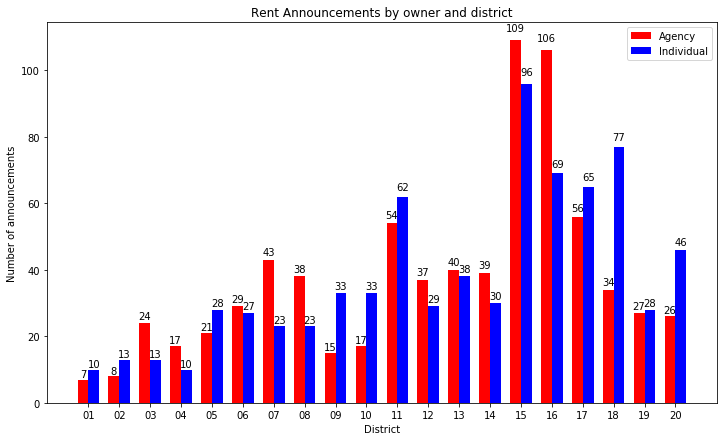

In [12]:
generateBarChartForAnnouncements()
# Agencies have an hyper activity in the 15 and 16th districts.
# In other districts we have a similar activities for Individual and agencies.

This Vizualisation aims to show users which district would be more interesting for them based on their choice.
For example if user want a 2 rooms appart. it's maybe more easy to rent an appart in the 18th, 17th or 15th district than another district.

In [13]:
def getNumberOfRoomsByDistrict():
    ListArrond = [str(elt) for elt in sorted(df_Viz["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    maxOfRooms = df_Viz["Rooms Number"].max() #Getting max OF rooms number in our dataFrame
    minOfRooms = df_Viz["Rooms Number"].min() #Getting min OF rooms number in our dataFrame
    #Init the stats
    for elt in ListArrond :
        StatsPerCategoryDistrict[elt] = [0]*(maxOfRooms-minOfRooms+1) #Supposing that we have 0 rooms count for each appart nulber of rooms
    
    #updating Number oF rooms 
    iterableFiltredData = df_Viz.groupby(["Zip Code","Rooms Number"]).size().iteritems()
    for ((ZipCode,roomsNumber),count) in iterableFiltredData : 
        StatsPerCategoryDistrict[str(ZipCode)][roomsNumber-1]=count 
    
    #Transforming list to Tuple for the matplotLib
    for key in StatsPerCategoryDistrict:
        StatsPerCategoryDistrict[key]=tuple(StatsPerCategoryDistrict[key]) # Getting tuple from list
    
    #ploting Part
    ArrayNumberOfRooms = tuple([cpt for cpt in range(minOfRooms,maxOfRooms+1)]) #Getting Tuple of rooms possible number
    row = 1
    column = 0 
    grid  = (int(len(ListArrond)/3)+2,3)
    fig = plt.subplots(squeeze=False,figsize=(10, 20))
    for key in StatsPerCategoryDistrict:
        #plotting coordinates calculating
        column = column + 1
        if(column % 4 == 0 ):
            row = row + 1
            column = 1
        ax = plt.subplot2grid(grid, (row-1, column-1))# placing the subplot on the grid
        ax.bar(ArrayNumberOfRooms, StatsPerCategoryDistrict[key])
        ax.set_ylabel('nb apparts',fontsize=8)# Y axix label
        ax.set_xlabel('nb rooms',fontsize=8) # X axix label
        ax.set_title(" nb apparts by room's number for "+key,fontsize=8) #settigna  title
        ax.set_xticks(ArrayNumberOfRooms) #Showing all range of number of rooms on the x axis
        ax.set_yticks(StatsPerCategoryDistrict[key], minor=True) #Showing all range of number of rooms on the x axis
        
    plt.tight_layout()
    plt.show()

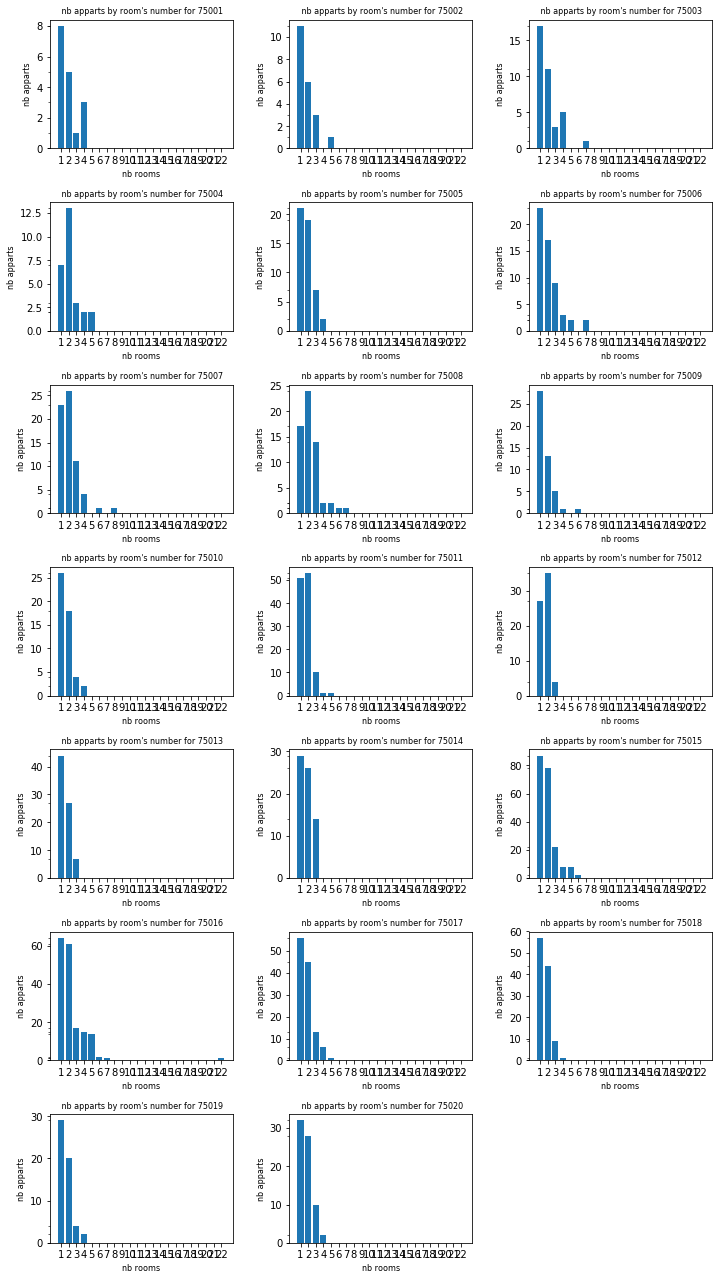

In [14]:
getNumberOfRoomsByDistrict()

This Function aims to show user amounts of meter square rent in the district of paris.
It aims also to show him the difference between an agency and an individual meter sqaure rent's amount.
It will also show him the difference between the real amount and the amout fixed by the frensh government.

In [15]:
def getMeanRentAmoutSquareMeterByDistrict():
    #Getted Amount from http://www.linternaute.com/argent/immobilier/prix-au-m-l-immobilier-dans-600-villes-de-france/paris.shtml
    officalAmounts=[37.31,33.70,36.26,37.69,34.41,36.70,34.86,36.71,30.57,28.34,30.47,28.34,28.48,28.81,29.49,30.43,30.79,28.60,25.09,25.91]
    ListArrond = [str(elt) for elt in sorted(df_Viz["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    for elt in ListArrond :
        StatsPerCategoryDistrict[elt] = {"averageIndiv":[],"averageAgency":[]}

    #Regrouping dataFrame columns by zipCode and Area and type of Rent. --> Deducting the unit price of a square meter
    filtredData = df_Viz.groupby(["Zip Code","Rent(€)","Area","Rent from Agency"]).size().iteritems()
    for ((ZipCode,rent,area,isAgency),count) in filtredData : #Filtering on Ads Owner and Zip Codes
            if(int(isAgency) == 0):
                StatsPerCategoryDistrict[str(ZipCode)]["averageIndiv"].append(float(rent)/float(area))
            else:
                StatsPerCategoryDistrict[str(ZipCode)]["averageAgency"].append(float(rent)/float(area))

    averageRentMeterIndividual = []
    averageRentMeterAgency = []
    for elem in ListArrond:
        #get avg from list:
        averageIndividual = sum(StatsPerCategoryDistrict[elem]["averageIndiv"]) / float(len(StatsPerCategoryDistrict[elem]["averageIndiv"])) #avg from list of float
        averageAgency = sum(StatsPerCategoryDistrict[elem]["averageAgency"]) / float(len(StatsPerCategoryDistrict[elem]["averageAgency"])) #avg from list of float
        #Constructing list of plots
        averageRentMeterIndividual.append(averageIndividual)
        averageRentMeterAgency.append(averageAgency)
 
    #plotting After preparing data
    grid  = (3,1)
    #first schema
    fig = plt.subplots(squeeze=False,figsize=(10, 5))
    ax = plt.subplot2grid(grid, (0, 0))# placing the subplot on the grid
    line1 = ax.plot(ListArrond,averageRentMeterIndividual, linewidth=1,color="#f08080",
                     label='M² Rent Amount 2017',marker='o',markersize=4)
    line2 = ax.plot(ListArrond,officalAmounts, linewidth=1,color="black",
                     label='M² Rent Amount 2014',marker='o',markersize=4)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)],fontsize=6)
    ax.legend(loc="best")
    #line1.set_dashes(dashes)
    #get Data of meter square rent price from somewhere on the net then display it in the same Graph
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('District',fontsize=7)
    ax.set_title('Meter Square Rent Amout Average for Individual Apparts by district',fontsize=8)
    plt.tight_layout()

    #second schema
    ax = plt.subplot2grid(grid, (1, 0))# placing the subplot on the grid
    line1 = ax.plot(ListArrond,averageRentMeterAgency, linewidth=1,color="#f08080",
                     label='M² Rent Amount 2017',marker='o',markersize=4)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)],fontsize=6)
    line2 = ax.plot(ListArrond,officalAmounts, linewidth=1,color="black",
                     label='M² Rent Amount 2014',marker='o',markersize=4)

    ax.legend(loc="best")
    #line1.set_dashes(dashes)
    #get Data of meter square rent price from somewhere on the net then display it in the same Graph
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('District',fontsize=7)
    ax.set_title('Meter Square Rent Amout Average for Agencies Apparts by district',fontsize=8)
    plt.tight_layout()

    #Third schema
    ax = plt.subplot2grid(grid, (2, 0))# placing the subplot on the grid
    line1 = ax.plot(ListArrond,averageRentMeterAgency, linewidth=1,color="#f08080",
                     label='Agencies M² Rent  Amount 2017',marker='o',markersize=4)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)],fontsize=6)
    line2 = ax.plot(ListArrond,averageRentMeterIndividual, linewidth=1,color="black",
                     label='Individuals M² Rent Amount 2017',marker='o',markersize=4)

    #line1.set_dashes(dashes)
    #get Data of meter square rent price from somewhere on the net then display it in the same Graph
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('District',fontsize=7)
    ax.set_title('Meter Square Rent Amout Average for Agencies Apparts and Individuals by district',fontsize=8)   
    ax.legend(loc="best")

    plt.show() 


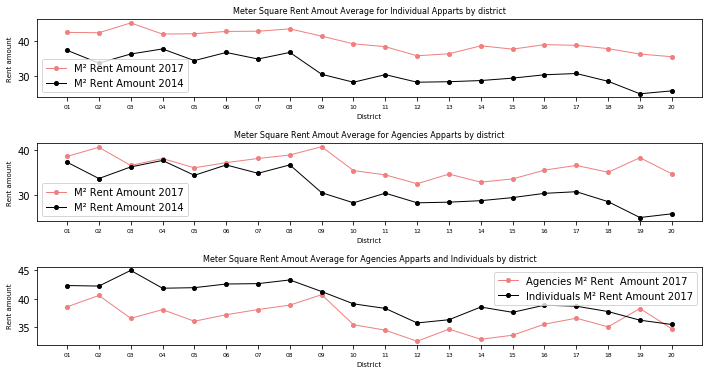

In [16]:
getMeanRentAmoutSquareMeterByDistrict()

In [17]:
def RepartFurnished():
    
    ListArrond = [str(elt) for elt in sorted(df_Viz["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    for elt in ListArrond :
            StatsPerCategoryDistrict[elt] ={}
            StatsPerCategoryDistrict[elt]["Indiv"]={"furnished":0,"unfurnished":0}
            StatsPerCategoryDistrict[elt]["Agency"]={"furnished":0,"unfurnished":0}

    
    #Regrouping dataFrame columns by zipCode and Area and type of Rent. --> Deducting the unit price of a square meter
    filtredData = df_Viz.groupby(["Zip Code","is furnished","Rent from Agency"]).size().iteritems()
    for ((ZipCode,isfurnished,isAgency),count) in filtredData : #Filtering on Ads Owner and Zip Codes
        if(isAgency == 0):
            if(isfurnished == 0):
                StatsPerCategoryDistrict[str(ZipCode)]["Indiv"]["unfurnished"] = count
            else:
                StatsPerCategoryDistrict[str(ZipCode)]["Indiv"]["furnished"] = count
        else:
            if(isfurnished == 0):
                StatsPerCategoryDistrict[str(ZipCode)]["Agency"]["unfurnished"] = count
            else:
                StatsPerCategoryDistrict[str(ZipCode)]["Agency"]["furnished"] = count

                
    AgencyFunishedRepartiotion = [0,0]
    IndividualFunishedRepartiotion = [0,0]      
    for zipCode in StatsPerCategoryDistrict:            
        AgencyFunishedRepartiotion[0]=AgencyFunishedRepartiotion[0]+StatsPerCategoryDistrict[zipCode]["Agency"]["furnished"]
        AgencyFunishedRepartiotion[1]=AgencyFunishedRepartiotion[1]+StatsPerCategoryDistrict[zipCode]["Agency"]["unfurnished"]
        IndividualFunishedRepartiotion[0]=IndividualFunishedRepartiotion[0]+StatsPerCategoryDistrict[zipCode]["Indiv"]["furnished"]
        IndividualFunishedRepartiotion[1]=IndividualFunishedRepartiotion[1]+StatsPerCategoryDistrict[zipCode]["Indiv"]["unfurnished"]
        
        
        
    allUnfurnishedApparts = 0
    allfurnishedApparts = 0
    filtredData = df_Viz.groupby(["is furnished"]).size().iteritems()
    for (isfurnished,count) in filtredData : #Filtering on Ads Owner and Zip Codes
        if(isfurnished):
            allfurnishedApparts = count
        else:
            allUnfurnishedApparts = count
                
    

    #plotting After preparing data
    grid  = (1,3)
    #first schema
    fig = plt.subplots(squeeze=False,figsize=(12, 4))

    labels = ('furnished apparts', 'unfurnished apparts')
    colored=["#42e1f9","#fcb315"]
    explode = (0, 0.08)  # only "explode" the 2nd slice (i.e. 'Hogs')
    
    ax1 = plt.subplot2grid(grid, (0, 0))# placing the subplot on the grid
    ax1.pie([allfurnishedApparts,allUnfurnishedApparts], explode=explode, labels=labels, autopct='%1.1f%%',colors=colored,shadow=True)
    plt.title('Repartition of Apparts', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)
    
    ax1 = plt.subplot2grid(grid, (0, 1))# placing the subplot on the grid
    ax1.pie(IndividualFunishedRepartiotion, explode=explode, labels=labels, autopct='%1.1f%%',colors=colored,shadow=True)
    plt.title('Repartition of Individual Apparts', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)

    ax1 = plt.subplot2grid(grid, (0, 2))# placing the subplot on the grid
    ax1.pie(AgencyFunishedRepartiotion, explode=explode, labels=labels, autopct='%1.1f%%',colors=colored,shadow=True)
    plt.title('Repartition of Agencies Apparts', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)

    plt.show()


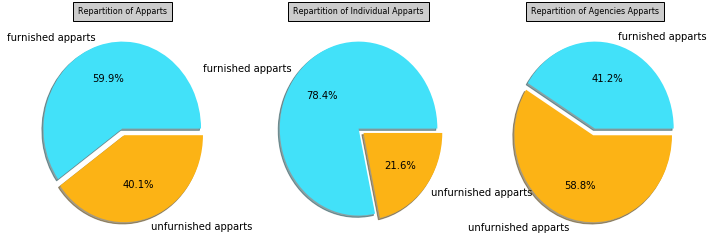

In [18]:
RepartFurnished()  #Ok done with Viz  

### Machine Learning

After scrapping data and preparing it in a data frame we are now able to attack the machine learning models, we'll compare them and choose the most adapted one. In this part we'll devide dataframe into test and traning sets.
Add Data that we'll exploit later

In [19]:
df_Ml = pd.read_excel('./DB_ML.xlsx') # Getting DB For machien Learning and Vizualisation. 
df_Ml_Test = pd.read_excel('./DB_ML_TEST.xlsx') # Getting DB For machien Learning and Vizualisation. 



df_TrainpredictedValue = df_Ml[["Rent(€)"]] #Extracting The prediction Value
df_TestpredictedValue = df_Ml_Test[["Rent(€)"]] #Extracting The prediction Value

df_TrainingExplainingValues = df_Ml[["Rooms Number","is furnished","Area","Rent from Agency"]] #Extracting The explaining Values
df_TestExplainingValues = df_Ml_Test[["Rooms Number","is furnished","Area","Rent from Agency"]] #Extracting The explaining Values




In [20]:
def getRentAmountPerAreaAndDisctrict():
    
    ListArrond = [str(elt) for elt in sorted(df_Ml["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    row = 1
    column = 0 
    grid  = (int(len(ListArrond)/3)+2,3)
    fig, ax = plt.subplots(figsize=(12, 7))
    for key in ListArrond:
        #plotting coordinates calculating
        column = column + 1
        if(column % 4 == 0 ):
            row = row + 1
            column = 1
        dfPerDistrict= df_Ml[df_Ml['Zip Code'] == int(key)]
        sns.regplot(x='Area',y='Rent(€)',data=dfPerDistrict,truncate =True,label=key)
        ax.legend(loc="best")
        plt.title('Varation of the Rent Amount by district', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)

    plt.tight_layout()
    plt.show()
    display(HTML("<div><h6> --> We Observe that the effect of the district is very important on the rent amount</h6></div>"))

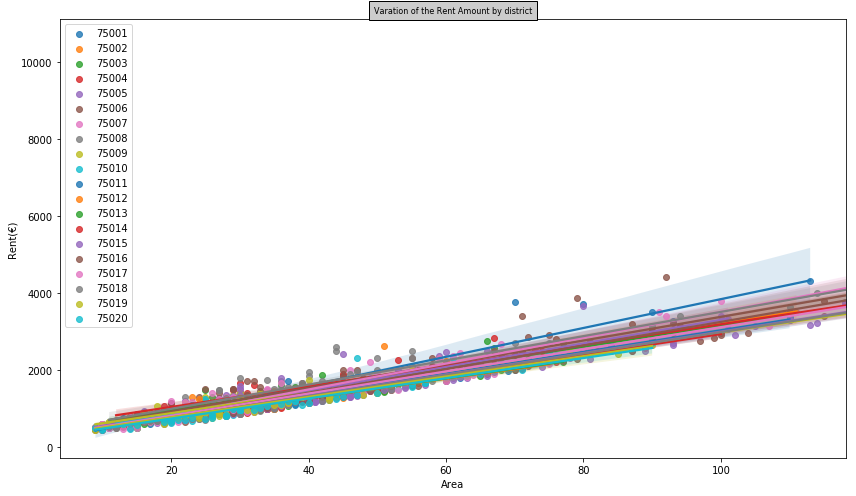

In [21]:
getRentAmountPerAreaAndDisctrict()

,Rooms Number,is furnished,Area,Rent from Agency
Rooms Number,1.000000,-0.161881,0.790893,0.151803
is furnished,-0.161881,1.000000,-0.247807,-0.378659
Area,0.790893,-0.247807,1.000000,0.248974
Rent from Agency,0.151803,-0.378659,0.248974,1.000000


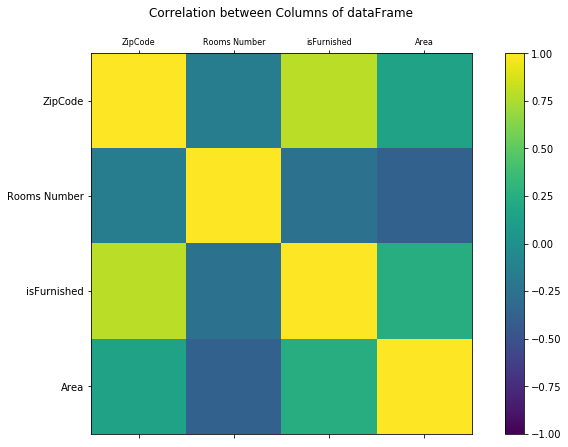

In [22]:
#Getting correlation between df Columns
Correlation = df_TrainingExplainingValues.corr()
names = ["ZipCode","Rooms Number","isFurnished","Area","isPro"]
display(Correlation)

#Plotting other Correlations
fig,ax= plt.subplots(figsize=(12, 7))
cax=ax.matshow(Correlation,vmin=-1,vmax=1)
fig.colorbar(cax)
ticks=np.arange(0,4,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names,fontsize=8)
ax.set_yticklabels(names)
plt.title("Correlation between Columns of dataFrame",y=1.08)
plt.show()


In [23]:
# Very high positive correlation (0.849203) between Rooms Number & Area so we choosed to drop this column. 
# There is a linear relation between these columns so risk that we obtain a biaised model.
# This drop action of one of the column will reduce calculations complexity and we'll have an unbiaised model.

df_TrainingExplainingValues = df_TrainingExplainingValues.drop("Rooms Number", axis=1)
df_TestExplainingValues = df_TestExplainingValues.drop("Rooms Number", axis=1)


ZipCodes = df_Ml[["Zip Code"]].values.tolist() #Extracting The prediction Value
ZipCodes = [int((str(zipCode))[-3:-1]) for zipCode in ZipCodes ] #getting district number
df_TrainingExplainingValues = df_TrainingExplainingValues.assign(ZipCode = ZipCodes) # adding the new column to the data Frame

ZipCodes = df_Ml_Test[["Zip Code"]].values.tolist() #Extracting The prediction Value
ZipCodes = [int((str(zipCode))[-3:-1]) for zipCode in ZipCodes ] #getting district number
df_TestExplainingValues = df_TestExplainingValues.assign(ZipCode = ZipCodes) # adding the new column to the data Frame

training = {"exogene":df_TrainingExplainingValues,"endogene":df_TrainpredictedValue } #Json Contaning Traning dataFrame 
test = {"exogene":df_TestExplainingValues,"endogene":df_TestpredictedValue } #Json Contaning Test dataFrame 


In [24]:
def MLTraining():
    
    # Split the data into training/testing sets
    train_X = training["exogene"]
    test_X =  test["exogene"]

    # Split the targets into training/testing sets
    train_y = training["endogene"]
    test_y = test["endogene"]
    
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(train_X, train_y)

    # Make predictions using the testing set
    Rent_pred = regr.predict(test_X)
    
    residuals = test_y - Rent_pred
    print("Residuals Informations :D ")
    print(residuals.describe())

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(test_y, Rent_pred))
    
    
    # Plot outputs
    obs = [cpt for cpt in range(1,len(test_y["Rent(€)"].values.tolist())+1)]
    rentPredList = [elt[0] for elt in Rent_pred]
    rentSeriesPrediction = pd.Series(rentPredList)
    rentSeriesTest = pd.Series(test_y["Rent(€)"].values.tolist())
    obsSeries = pd.Series(obs)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.regplot(x=obsSeries,y=rentSeriesPrediction,truncate =True,color="red",marker="*",label="Predicted Values")
    ax.scatter(obs, rentSeriesTest, color='blue', linewidth=2,label="Real Values")
    ax.set_xticks(obs) #Showing all range of number of rooms on the x axis
    ax.set_yticks(Rent_pred, minor=True) #Showing all range of number of rooms on the x axis
    #line1.set_dashes(dashes)
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('Test Observation number',fontsize=7)
    ax.set_title('Prediction and real Value in test set',fontsize=8)
    plt.tight_layout()
    ax.legend(loc="best")
    plt.show()
    return regr.coef_

Residuals Informations :D 
           Rent(€)
count   149.000000
mean     43.276319
std     387.640895
min    -454.435135
25%    -122.130119
50%      -6.528241
75%      83.992753
max    2936.715570
Coefficients: 
 [[ 114.51290015   30.83285591   -6.70447941  -12.80577107]]
Variance score: 0.90


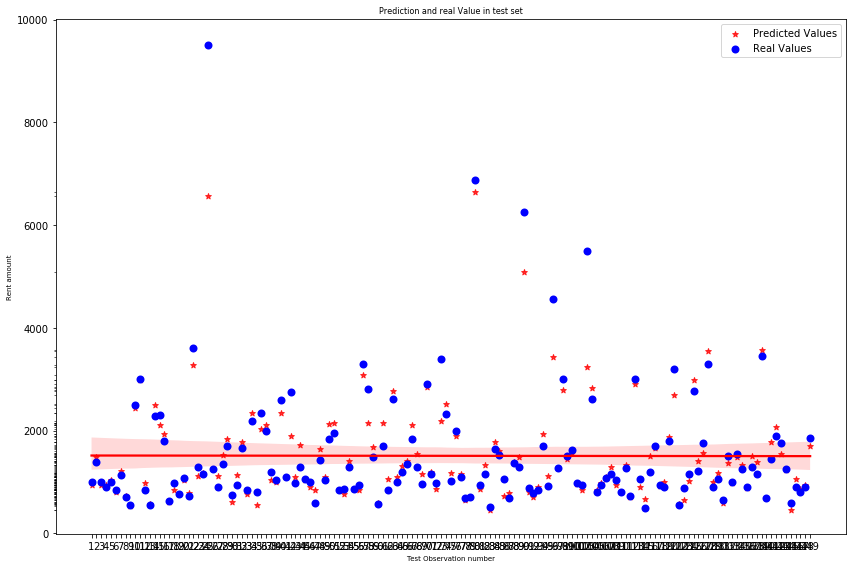

In [25]:
# Coef Format = is furnished	Area	Rent from Agency	ZipCode
Coef=MLTraining()[0] #Getting the Coefficients for the Linear Regression

We observe that the mean's prediction errors is 43€.
We observe also that our algorithm performs well for appartement with a rent between 400€ and 4000€
So maybe we could have another  algorithm which treats these cases. Implicitally we have to divide apparts to two classes for example to handle both of appart's classes. 

#### Example of use (e.g On Production Platforme )

In [28]:
validTest =[0,43,1,7] 
#Information of an appart (unfurnished, Area = 43m², is Rented by an Agency, located in the 7th district) Real value = 1254€
#Link : http://www.logic-immo.com/detail-location-6952f640-48ae-569d-9c84-617369af7f56.htm 
rent = 0
for j in range(0,len(Coef)):
    rent = rent + (Coef[j]*validTest[j])
print(rent)

1229.46792717


This was a POC, we"re still waiting for a positive response from LEBONCOIN. We wanted at the first time to detect Fraudulent
appart's Announcement but we didn't get a data set from the site even when we contacted them.
Now we are waiting for another response maybe we'll treat the problem that we have choosed at first.
Thank You.
Best Regards.